In [5]:
cd "C:\Users\61424\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame"

C:\Users\61424\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame


In [23]:
from scipy.io import loadmat, savemat
import numpy as np
import networkx as nx
from edamame import *
from edamame.analysis.misc import draw_zp_space
import nct
import bct

In [11]:
data=loadmat(r'C:\Users\61424\Dropbox (Sydney Uni)\Data\ASN_simulation\Python\edamame\edamame\connectivity_data\100nw_261junctions.mat')

In [12]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'yi', 'xa', 'edge_list', 'xb', 'xc', 'yc', 'yb', 'avg_length', 'length_y', 'xi', 'theta', 'adj_matrix', 'number_of_junctions', 'this_seed', 'number_of_wires', 'dispersion', 'ya', 'outside', 'wire_distances', 'length_x', 'GraphProperties', 'Equations'])

In [16]:
graph=nx.from_numpy_matrix(data['adj_matrix'])

In [27]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

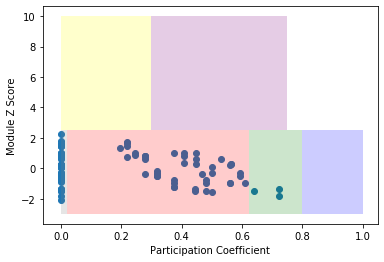

In [25]:
ci,q=nct.community_louvain(data['adj_matrix'])
pcoeff=bct.participation_coef(data['adj_matrix'],ci)
mz=bct.module_degree_zscore(data['adj_matrix'],ci)

plt.scatter(pcoeff,mz)
draw_zp_space(ax=plt.gca())

(0, 1)

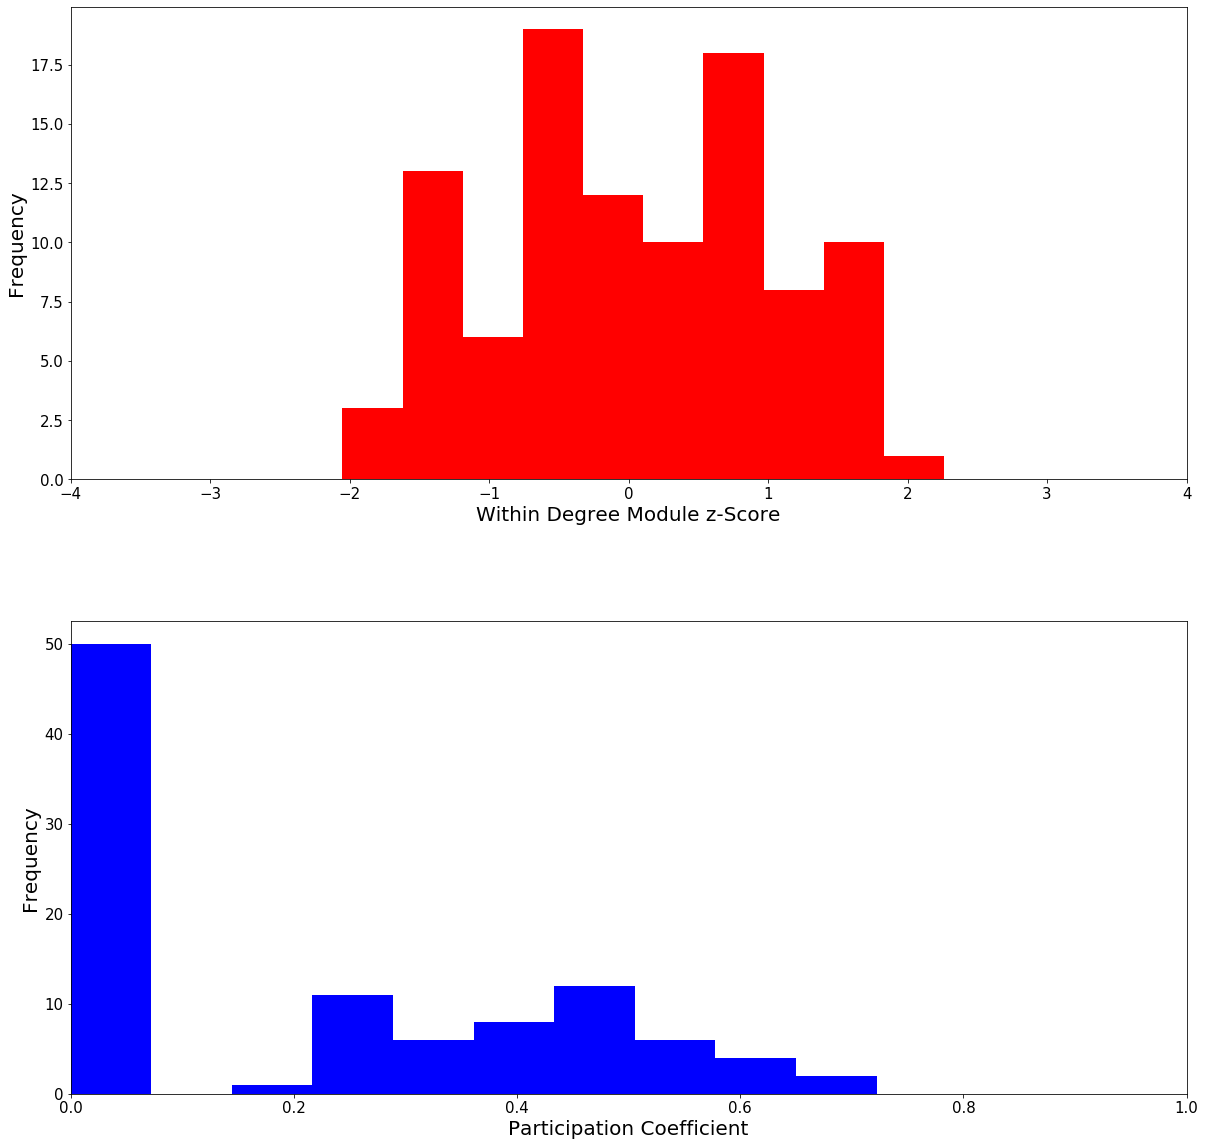

In [45]:
#Histograms for PCoeff:
ax=[None]*2
fig=plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)
ax[0]=plt.subplot(2,1, 1)
plt.hist(mz,color='r')            
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Within Degree Module z-Score',fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[0].tick_params(axis='both', which='minor', labelsize=15)
#                 ax[j].set_ylim(0, 70)
ax[0].set_xlim(-4,4)      

ax[1]=plt.subplot(2,1, 2)
plt.hist(pcoeff,color='b')            
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('Participation Coefficient',fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=15) #change size of label ticks
ax[1].tick_params(axis='both', which='minor', labelsize=15)
#     ax[i].set_ylim(0, 200)
ax[1].set_xlim(0,1)

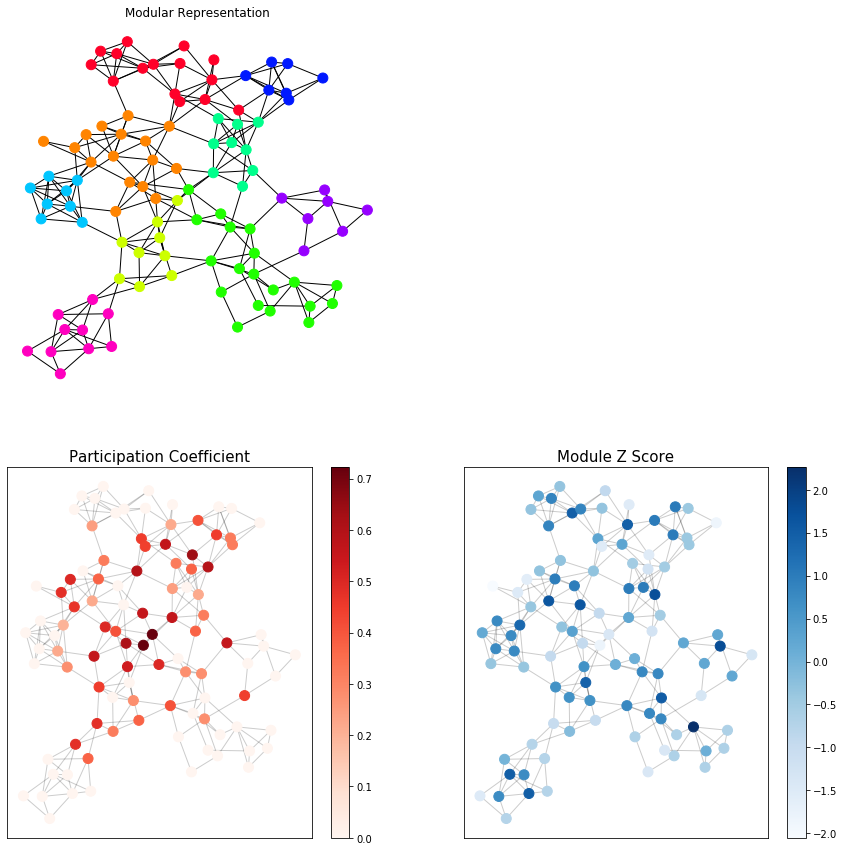

In [81]:
from community import community_louvain
fig2=plt.figure(figsize=(15,15))

ax=[None]*3
axBig = fig2.add_subplot(111)
axBig.set_yticklabels([])
plt.xticks([], [])
plt.yticks([], [])
axBig.set_xticklabels([])
axBig.set_frame_on(False)
g=graph
partition = community_louvain.best_partition(g)
pos = nx.kamada_kawai_layout(g)

# ax[0]=fig2.add_subplot(2, 1, 1)
# ax[0].set_title('Graphical Representation')
# nx.draw(g,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);
ax[0]=fig2.add_subplot(2, 2, 1)
ax[0].set_title('Modular Representation')
nx.draw(g, pos,node_color=list(partition.values()),cmap=plt.cm.gist_rainbow,node_size=100);


ax[1]=fig2.add_subplot(2, 2, 3)
plt.title('Participation Coefficient',fontsize='15')

pos = nx.kamada_kawai_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc=nx.draw_networkx_nodes(g, pos, nodelist=g.nodes, node_color=pcoeff, 
                            with_labels=False, node_size=100, cmap=plt.cm.Reds)
plt.colorbar(nc)

ax[2]=fig2.add_subplot(2, 2, 4)
plt.title('Module Z Score',fontsize='15')
pos = nx.kamada_kawai_layout(g)
ec2 = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc2=nx.draw_networkx_nodes(g, pos, nodelist=g.nodes, node_color=mz, 
                            with_labels=False, node_size=100, cmap=plt.cm.Blues)
plt.colorbar(nc2)
